### Importing Libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

In [39]:
import sys
import os
helper_dir = os.path.join('..','HelperFunction')
sys.path.append(helper_dir)
import HelperFunction as helpers
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Getting the Data Ready

In [40]:
##define input
train_feature_file = 'data/train_features.csv'
train_target_file = 'data/train_salaries.csv'
test_feature_file = 'data/test_features.csv'

# Define variables
categorical_vars = ['companyId', 'jobType', 'degree', 'major', 'industry']
numerical_vars = ['yearsExperience', 'milesFromMetropolis']
target_vars = 'salary'
connecting_column = 'jobId'

# load data
print("Loading Data")
feature_df = helpers.load_dataset(train_feature_file)
target_df = helpers.load_dataset(train_target_file)
test_df = helpers.load_dataset(test_feature_file)

# Merge the training data
raw_train_df = helpers.consolidate_data(feature_df, target_df, key = connecting_column)

print("Cleaning Data")
clean_train_df = helpers.clean_data(raw_train_df, connecting_column, target_vars)

Loading Data
Cleaning Data


### 5. Establish a Baseline Model

In [42]:
# Encoding categorical data and get final feature dataframes
feature_df = helpers.label_Encoder(df1 = clean_train_df, cat_vars=categorical_vars, num_vars=numerical_vars, 
                                   engingeering=False)
# Getting the target Variable
target_df = helpers.get_target_df(clean_train_df, target_vars)
# BaseLine models 
lr = LinearRegression()
# train the model and Print Summary 
helpers.train_model(lr, feature_df, target_df)


Model:
 LinearRegression()
Average MSE:
 384.49421558178705
Standard deviation during cross validation:
 1.3986351678644837


### 6. Feature Engineering

We found from Exploratory data Analaysis Heatmap that:

There is a weak positive relationship (0.38) between salary and yearsExperience. There is a weak negative relationship between (-0.3) salary and milesFromMetropolis. The prediction will be unreliable with weak correaltion. Therefore, We will engineer new features to enhance model performance.

**New Features:Calculate descriptive statistics by aggregating categorical features (Eg: Group_mean, Group_min, Group_max, Group_std)**

In [43]:
fillna=True
# Create New Features:
GrpAvg_ds, GrpAvg_cols = helpers.FeatureEng_GrpAvg(clean_train_df, categorical_vars, target_vars)

# Merge new features with existing data
train_dataset = helpers.FeatureEng_merge(clean_train_df, GrpAvg_ds, categorical_vars, GrpAvg_cols, fillna)
test_dataset = helpers.FeatureEng_merge(test_df, GrpAvg_ds, categorical_vars, GrpAvg_cols, fillna)

# One hot Encoding
print("One Hot Encoding")
Label_encoders={}
for col in categorical_vars:
    train_dataset[col], test_dataset[col], Label_encoders[col] = helpers.label_Encoder(train_dataset,test_dataset, 
                                                                                       col, engingeering=True)    
# Updating Feature list
cat_cols_FE = categorical_vars + GrpAvg_cols
feature_cols = cat_cols_FE + numerical_vars
print("Shuffling the Data")
#Shuffling training dataset
train_dataset = helpers.shuffle_df(train_dataset)
print("Done!!!!")

One Hot Encoding
Shuffling the Data
Done!!!!


In [44]:
# initialise models list and metrics
models = []
mean_mse = {}
cv_std = {}
res = {}
# defining the number of processors
n_procs = 4
# set verbose level
verbose_lvl = 0

### Improving models with new features

In [45]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators = 80, n_jobs = n_procs, max_depth = 20, min_samples_split = 70,
                          max_features = 10, verbose = verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators = 40, max_depth = 7, loss = 'ls', verbose = verbose_lvl)
models.extend([lr, rf, gbm])

print('Cross validating the models')
for model in models:
    helpers.cross_val_model(model, train_dataset[feature_cols], train_dataset[target_vars],n_procs ,mean_mse, cv_std)
    helpers.print_summary(model, mean_mse, cv_std)

Cross validating the models

model:
 LinearRegression()
Average MSE:
 358.1688669529415
Standard deviation during cross validation:
 0.6289748878530759

model:
 RandomForestRegressor(max_depth=20, max_features=10, min_samples_split=70,
                      n_estimators=80, n_jobs=4)
Average MSE:
 314.8854714009659
Standard deviation during cross validation:
 0.9037294215536917

model:
 GradientBoostingRegressor(max_depth=7, n_estimators=40)
Average MSE:
 313.3603866995765
Standard deviation during cross validation:
 0.8787453323400882


### Selecting the best model based on MSE

In [46]:
bestModel = min(mean_mse, key = mean_mse.get)
print('The best model based on MSE during cross validation:')
print(bestModel)

The best model based on MSE during cross validation:
GradientBoostingRegressor(max_depth=7, n_estimators=40)


In [47]:
bestModel.fit(train_dataset[feature_cols], train_dataset[target_vars])

GradientBoostingRegressor(max_depth=7, n_estimators=40)

In [48]:
predicted_salaries = bestModel.predict(test_dataset[feature_cols])

### Feature Importance

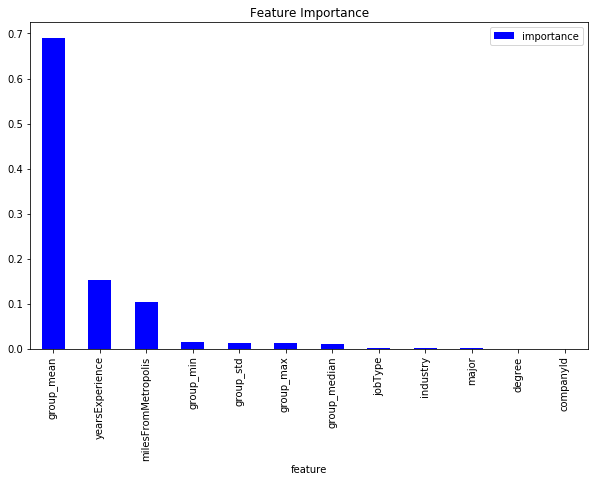

In [50]:
feature_importances = helpers.get_model_feature_importances(bestModel, train_dataset[feature_cols])
feature_importances.plot.bar(figsize=(10,6),color='Blue')
plt.title("Feature Importance");

Based on the above plot, we can certainly say that **group_mean** is the most important feature for predicting job salaries followed by **yearsExperience**

### Saving Model for Future Use

In [55]:
helpers.save_results(model, mean_mse[model], predicted_salaries, feature_importances)

In [56]:
!cat model.txt

GradientBoostingRegressor(max_depth=7, n_estimators=40)

In [57]:
!head feature_importances

feature,importance
group_mean,0.6901693490010732
yearsExperience,0.15248262641660587
milesFromMetropolis,0.10451401299970714
group_min,0.015269214155258682
group_std,0.013360634692380203
group_max,0.011826084568438673
group_median,0.0100316044447755
jobType,0.0015271893837683773
industry,0.0005911511090934875


In [58]:
!head predictions.csv

1.158068728340799538e+02
8.721737653740480312e+01
1.660214392148803881e+02
1.093808114078834279e+02
1.075035553838071110e+02
1.591616837435202001e+02
1.083489660262361411e+02
1.306538562718167782e+02
1.013333171425995829e+02
9.760339886383607677e+01
